<a href="https://colab.research.google.com/github/Mohaiminul-IslamT/IBM-Advanced-Data-Science/blob/master/Surface%20roughness%20methodology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Linear Regression Model using 1% to identify Surface Roughness

Original Data:
  Experiment No.  Spindle speed (rpm)  Feed Rate (mm/min)  Depth of cut (mm)  \
0             1A                  175                  40                0.1   
1             2A                  175                  40                0.3   
2             3A                  175                  40                0.5   
3             4A                  175                  93                0.1   
4             5A                  175                  93                0.3   

   Surface Roughness (æm)  MRR(mm3/min)  
0                  4.1331       247.986  
1                  4.5021       270.126  
2                  5.9296       355.776  
3                  4.6265       277.590  
4                  4.6471       278.826  

Augmented Data Head:
  Experiment No.  Spindle speed (rpm)  Feed Rate (mm/min)  Depth of cut (mm)  \
0             1A                175.0                40.0                0.1   
1             2A                175.0                40.0             

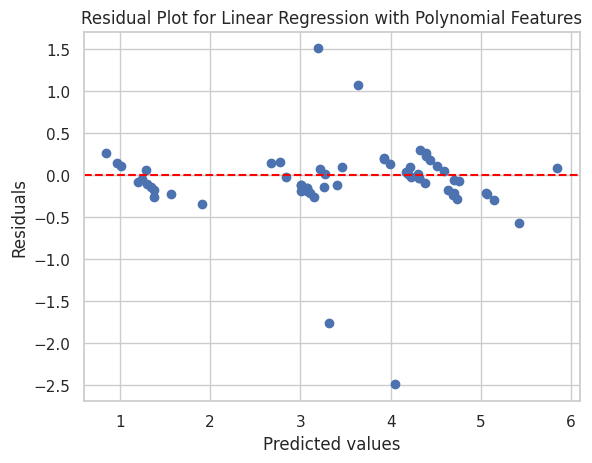

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline

#augment data
def augment_data(data, num_samples=10, perturbation_factor=0.05):
    augmented_data = [data.copy()]
    for _ in range(num_samples):
        new_data = data.copy()
        for i in range(len(data)):
            new_row = new_data.iloc[i].copy()
            new_row['Spindle speed (rpm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Spindle speed (rpm)']
            new_row['Feed Rate (mm/min)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Feed Rate (mm/min)']
            new_row['Depth of cut (mm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Depth of cut (mm)']
            augmented_data.append(pd.DataFrame([new_row]))
    return pd.concat(augmented_data, ignore_index=True)

# Load dataset
data = pd.read_csv('/content/1.csv.csv', encoding='ISO-8859-1')

# Data augmentation
print("Original Data:")
print(data.head())

# Augment the data
augmented_data = augment_data(data, num_samples=10)

# Print augmented data
print("\nAugmented Data Head:")
print(augmented_data.head())

# Features and targets
X = augmented_data[['Spindle speed (rpm)', 'Feed Rate (mm/min)', 'Depth of cut (mm)']]
y = augmented_data['Surface Roughness (æm)']

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

poly = PolynomialFeatures(include_bias=False, interaction_only=False)

# Pipeline for polynomial features and linear regression
pipeline = make_pipeline(poly, LinearRegression())


param_grid = {
    'polynomialfeatures__degree': [2, 3, 4],
    'linearregression__fit_intercept': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_scaled, y)

best_model = grid_search.best_estimator_
print(f"Best hyperparameters found: {grid_search.best_params_}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

best_model.fit(X_train, y_train)

# Predict
y_pred_1_sr = best_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred_1_sr)
r2 = r2_score(y_test, y_pred_1_sr)
evs = explained_variance_score(y_test, y_pred_1_sr)
mape = mean_absolute_percentage_error(y_test, y_pred_1_sr)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Explained Variance Score: {evs}")
print(f"Mean Absolute Percentage Error: {mape}")

# Cross-validation
scores = cross_val_score(best_model, X_scaled, y, cv=5, scoring='r2')
print(f"Cross-validated R-squared: {scores.mean()}")

#prediction for a new data point
new_data = pd.DataFrame({
    'Spindle speed (rpm)': [320],
    'Feed Rate (mm/min)': [200],
    'Depth of cut (mm)': [0.3]
})

# Transform the new data point
new_data_scaled = scaler.transform(new_data)

# Predict Surface Roughness (æm) for new data
predicted_mrr = best_model.predict(new_data_scaled)
print(f"Predicted Surface Roughness (æm) for input [400, 150, 0.5]: {predicted_mrr[0]}")

# Ploting residuals
residuals = y_test - y_pred_1_sr
plt.scatter(y_pred_1_sr, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Linear Regression with Polynomial Features')
plt.axhline(0, color='red', linestyle='--')
plt.show()

2. SVM using 1% to identify Surface Roughness

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best SVM hyperparameters: {'polynomialfeatures__degree': 3, 'svr__C': 10, 'svr__epsilon': 0.1, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}
SVM with Polynomial Features - MSE: 0.19563121721037813, R²: 0.8930116011570486, EVS: 0.8962793847936309, MAPE: 0.09171236345171892
Cross-validated R-squared: 0.9244713833514456
Predicted Surface Roughness (æm) for input [400, 150, 0.5]: 4.5576362221466855


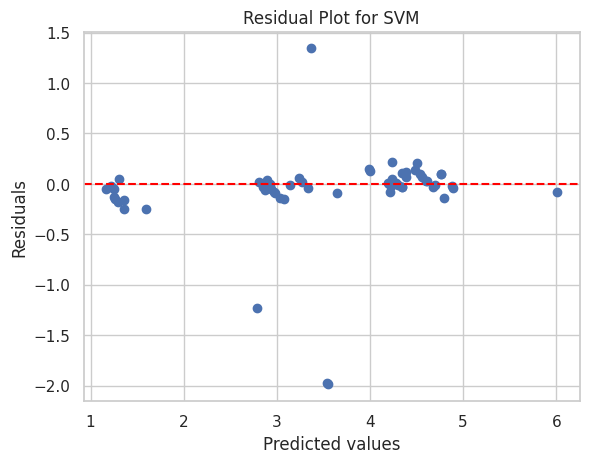

In [3]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

def augment_data(data, num_samples=10, perturbation_factor=0.05):
    augmented_data = [data.copy()]
    for _ in range(num_samples):
        new_data = data.copy()
        for i in range(len(data)):
            new_row = new_data.iloc[i].copy()
            new_row['Spindle speed (rpm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Spindle speed (rpm)']
            new_row['Feed Rate (mm/min)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Feed Rate (mm/min)']
            new_row['Depth of cut (mm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Depth of cut (mm)']
            augmented_data.append(pd.DataFrame([new_row]))
    return pd.concat(augmented_data, ignore_index=True)

data = pd.read_csv('/content/1.csv.csv', encoding='ISO-8859-1')

augmented_data = augment_data(data, num_samples=10)

X = augmented_data[['Spindle speed (rpm)', 'Feed Rate (mm/min)', 'Depth of cut (mm)']]
y = augmented_data['Surface Roughness (æm)']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
poly_svm_pipeline = make_pipeline(PolynomialFeatures(), StandardScaler(), SVR())

param_grid_svm = {
    'svr__kernel': ['rbf', 'poly'],
    'svr__C': [1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.5],
    'svr__gamma': ['scale', 'auto'],
    'polynomialfeatures__degree': [2, 3, 4]
}

grid_search_svm = GridSearchCV(poly_svm_pipeline, param_grid_svm, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svm.fit(X_scaled, y)

best_poly_svm_model = grid_search_svm.best_estimator_
print(f"Best SVM hyperparameters: {grid_search_svm.best_params_}")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

best_poly_svm_model.fit(X_train, y_train)

y_pred_1_svm_poly = best_poly_svm_model.predict(X_test)

mse_svm_poly = mean_squared_error(y_test, y_pred_1_svm_poly)
r2_svm_poly = r2_score(y_test, y_pred_1_svm_poly)
evs_svm_poly = explained_variance_score(y_test, y_pred_1_svm_poly)
mape_svm_poly = mean_absolute_percentage_error(y_test, y_pred_1_svm_poly)
print(f"SVM with Polynomial Features - MSE: {mse_svm_poly}, R²: {r2_svm_poly}, EVS: {evs_svm_poly}, MAPE: {mape_svm_poly}")

# Cross-validation
scores_svm = cross_val_score(best_poly_svm_model, X_scaled, y, cv=5, scoring='r2')
print(f"Cross-validated R-squared: {scores_svm.mean()}")

new_data = pd.DataFrame({
    'Spindle speed (rpm)': [175],
    'Feed Rate (mm/min)': [93],
    'Depth of cut (mm)': [0.1]
})

new_data_scaled = scaler.transform(new_data)

predicted_ra_svm = best_poly_svm_model.predict(new_data_scaled)
print(f"Predicted Surface Roughness (æm) for input [400, 150, 0.5]: {predicted_ra_svm[0]}")

residuals_svm = y_test - y_pred_1_svm_poly
plt.scatter(y_pred_1_svm_poly, residuals_svm)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for SVM')
plt.axhline(0, color='red', linestyle='--')
plt.show()

3. RF using 1% to identify Surface Roughness

In [4]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

def augment_data(data, num_samples=10, perturbation_factor=0.05):
    augmented_data = [data.copy()]
    for _ in range(num_samples):
        new_data = data.copy()
        for i in range(len(data)):
            new_row = new_data.iloc[i].copy()
            new_row['Spindle speed (rpm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Spindle speed (rpm)']
            new_row['Feed Rate (mm/min)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Feed Rate (mm/min)']
            new_row['Depth of cut (mm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Depth of cut (mm)']
            augmented_data.append(pd.DataFrame([new_row]))
    return pd.concat(augmented_data, ignore_index=True)

data = pd.read_csv('/content/1.csv.csv', encoding='ISO-8859-1')

augmented_data = augment_data(data, num_samples=10)

X = augmented_data[['Spindle speed (rpm)', 'Feed Rate (mm/min)', 'Depth of cut (mm)']]
y = augmented_data['Surface Roughness (æm)']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

poly_rf_pipeline = make_pipeline(PolynomialFeatures(), StandardScaler(), RandomForestRegressor(random_state=42))

param_grid_rf = {
    'randomforestregressor__n_estimators': [100, 200, 500],  # Number of trees
    'randomforestregressor__max_depth': [10, 20, 30],  # Maximum depth of trees
    'randomforestregressor__min_samples_split': [2, 5, 10],  # Min samples to split a node
    'randomforestregressor__min_samples_leaf': [1, 2, 4],  # Min samples at a leaf node
    'polynomialfeatures__degree': [2, 3, 4]  # Polynomial feature degrees
}

grid_search_rf = GridSearchCV(poly_rf_pipeline, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_scaled, y)

best_poly_rf_model = grid_search_rf.best_estimator_
print(f"Best RF hyperparameters: {grid_search_rf.best_params_}")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

best_poly_rf_model.fit(X_train, y_train)

y_pred_1_rf_poly = best_poly_rf_model.predict(X_test)

mse_rf_poly = mean_squared_error(y_test, y_pred_1_rf_poly)
r2_rf_poly = r2_score(y_test, y_pred_1_rf_poly)
evs_rf_poly = explained_variance_score(y_test, y_pred_1_rf_poly)
mape_rf_poly = mean_absolute_percentage_error(y_test, y_pred_1_rf_poly)
print(f"Random Forest with Polynomial Features - MSE: {mse_rf_poly}, R²: {r2_rf_poly}, EVS: {evs_rf_poly}, MAPE: {mape_rf_poly}")

# Cross-validation
scores_rf = cross_val_score(best_poly_rf_model, X_scaled, y, cv=5, scoring='r2')
print(f"Cross-validated R-squared: {scores_rf.mean()}")

new_data = pd.DataFrame({
    'Spindle speed (rpm)': [175],
    'Feed Rate (mm/min)': [93],
    'Depth of cut (mm)': [0.1]
})

new_data_scaled = scaler.transform(new_data)

predicted_ra_rf = best_poly_rf_model.predict(new_data_scaled)
print(f"Predicted Surface Roughness (æm) for input [400, 150, 0.5]: {predicted_ra_rf[0]}")

# Plot residuals
residuals_rf = y_test - y_pred_1_rf_poly
plt.scatter(y_pred_1_rf_poly, residuals_rf)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Random Forest')
plt.axhline(0, color='red', linestyle='--')
plt.show()

KeyboardInterrupt: 

graph for 1% Zno (SR)

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Define the range for the test experiments
test_experiments = range(1, len(y_test) + 1)

# Create a larger figure size
plt.figure(figsize=(12, 8))

# Plot experimental results
sns.lineplot(x=test_experiments, y=y_test, label='Experimental Results', marker='o', color='blue', linewidth=3)

# Plot Linear Regression predictions
sns.lineplot(x=test_experiments, y=y_pred_1_sr, label='Predicted LR', marker='x', color='green', linewidth=2, linestyle='--')

# Plot SVM predictions
sns.lineplot(x=test_experiments, y=y_pred_1_svm_poly, label='Predicted SVM', marker='s', color='orange', linewidth=2, linestyle='-.')

# Plot Random Forest predictions
sns.lineplot(x=test_experiments, y=y_pred_1_rf_poly, label='Predicted RF', marker='d', color='red', linewidth=2, linestyle=':')

# Set labels and title
plt.xlabel('Test Experiments')
plt.ylabel('Surface Roughness (µm)')
plt.title('Predicted Surface Roughness vs Experimental Results for 1% Weight of ZnO')

# Add a legend to differentiate between the models
plt.legend()

# Display the plot with tight layout
plt.tight_layout()
plt.show()

NameError: name 'y_test' is not defined

4. Linear Regression Model using 1% to identify MRR

Original Data:
  Experiment No.  Spindle speed (rpm)  Feed Rate (mm/min)  Depth of cut (mm)  \
0             1A                  175                  40                0.1   
1             2A                  175                  40                0.3   
2             3A                  175                  40                0.5   
3             4A                  175                  93                0.1   
4             5A                  175                  93                0.3   

   Surface Roughness (æm)  MRR(mm3/min)  
0                  4.1331       247.986  
1                  4.5021       270.126  
2                  5.9296       355.776  
3                  4.6265       277.590  
4                  4.6471       278.826  

Augmented Data Head:
  Experiment No.  Spindle speed (rpm)  Feed Rate (mm/min)  Depth of cut (mm)  \
0             1A                175.0                40.0                0.1   
1             2A                175.0                40.0             

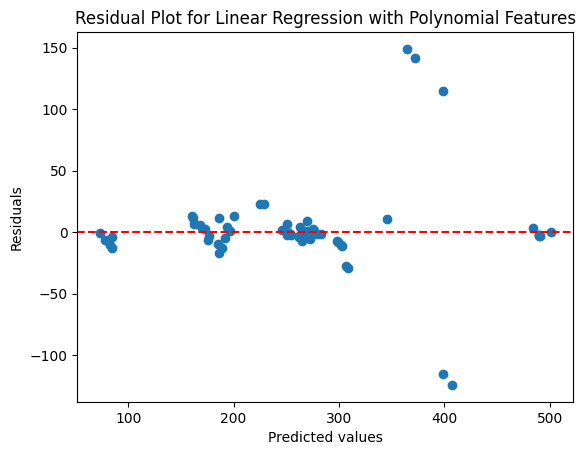

In [8]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline

def augment_data(data, num_samples=10, perturbation_factor=0.05):
    augmented_data = [data.copy()]
    for _ in range(num_samples):
        new_data = data.copy()
        for i in range(len(data)):
            new_row = new_data.iloc[i].copy()
            new_row['Spindle speed (rpm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Spindle speed (rpm)']
            new_row['Feed Rate (mm/min)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Feed Rate (mm/min)']
            new_row['Depth of cut (mm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Depth of cut (mm)']
            augmented_data.append(pd.DataFrame([new_row]))
    return pd.concat(augmented_data, ignore_index=True)

# Load dataset
data = pd.read_csv('/content/1.csv.csv', encoding='ISO-8859-1')

# Data augmentation
print("Original Data:")
print(data.head())

# Augment the data
augmented_data = augment_data(data, num_samples=10)

# Print augmented data
print("\nAugmented Data Head:")
print(augmented_data.head())

# Features and targets
X = augmented_data[['Spindle speed (rpm)', 'Feed Rate (mm/min)', 'Depth of cut (mm)']]
y = augmented_data['MRR(mm3/min)']

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

poly = PolynomialFeatures(include_bias=False, interaction_only=False)

pipeline = make_pipeline(poly, LinearRegression())

param_grid = {
    'polynomialfeatures__degree': [2, 3, 4],
    'linearregression__fit_intercept': [True, False]
}

# Hyperparameter tuning with GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_scaled, y)

best_model = grid_search.best_estimator_
print(f"Best hyperparameters found: {grid_search.best_params_}")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

best_model.fit(X_train, y_train)

y_pred_1_mrr = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_1_mrr)
r2 = r2_score(y_test, y_pred_1_mrr)
evs = explained_variance_score(y_test, y_pred_1_mrr)
mape = mean_absolute_percentage_error(y_test, y_pred_1_mrr)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Explained Variance Score: {evs}")
print(f"Mean Absolute Percentage Error: {mape}")

# Cross-validation
scores = cross_val_score(best_model, X_scaled, y, cv=5, scoring='r2')
print(f"Cross-validated R-squared: {scores.mean()}")

new_data = pd.DataFrame({
    'Spindle speed (rpm)': [175],  # example spindle speed
    'Feed Rate (mm/min)': [93],  # example feed rate
    'Depth of cut (mm)': [0.1]   # example depth of cut
})

new_data_scaled = scaler.transform(new_data)

predicted_mrr = best_model.predict(new_data_scaled)
print(f"Predicted MRR(mm3/min) for input [400, 150, 0.5]: {predicted_mrr[0]}")

# Plot residuals
residuals = y_test - y_pred_1_mrr
plt.scatter(y_pred_1_mrr, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Linear Regression with Polynomial Features')
plt.axhline(0, color='red', linestyle='--')
plt.show()

5. SVM using 1% to identify MRR

Best SVM hyperparameters: {'polynomialfeatures__degree': 3, 'svr__C': 100, 'svr__epsilon': 0.5, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
SVM with Polynomial Features - MSE: 2606.726786552788, R²: 0.804802190505815, EVS: 0.813913676091528, MAPE: 0.035986251556906
Cross-validated R-squared: 0.8500652353099298
Predicted MRR(mm3/min) for input [400, 150, 0.5]: 278.0898742589186


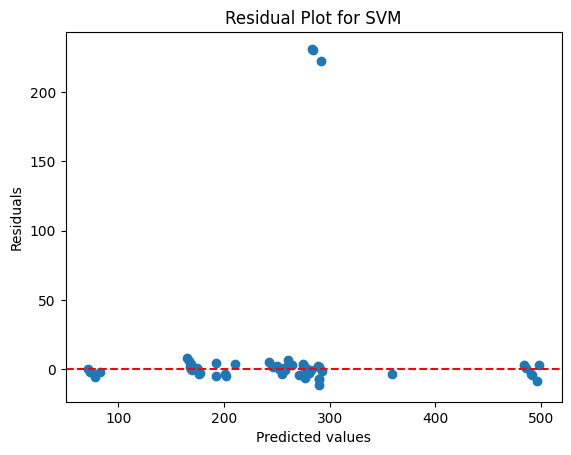

In [9]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

def augment_data(data, num_samples=10, perturbation_factor=0.05):
    augmented_data = [data.copy()]
    for _ in range(num_samples):
        new_data = data.copy()
        for i in range(len(data)):
            new_row = new_data.iloc[i].copy()
            new_row['Spindle speed (rpm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Spindle speed (rpm)']
            new_row['Feed Rate (mm/min)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Feed Rate (mm/min)']
            new_row['Depth of cut (mm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Depth of cut (mm)']
            augmented_data.append(pd.DataFrame([new_row]))
    return pd.concat(augmented_data, ignore_index=True)

data = pd.read_csv('/content/1.csv.csv', encoding='ISO-8859-1')

augmented_data = augment_data(data, num_samples=10)

X = augmented_data[['Spindle speed (rpm)', 'Feed Rate (mm/min)', 'Depth of cut (mm)']]
y = augmented_data['MRR(mm3/min)']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

poly_svm_pipeline = make_pipeline(PolynomialFeatures(), StandardScaler(), SVR())

param_grid_svm = {
    'svr__kernel': ['rbf', 'poly'],
    'svr__C': [1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.5],
    'svr__gamma': ['scale', 'auto'],
    'polynomialfeatures__degree': [2, 3, 4]
}

grid_search_svm = GridSearchCV(poly_svm_pipeline, param_grid_svm, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svm.fit(X_scaled, y)

best_poly_svm_model = grid_search_svm.best_estimator_
print(f"Best SVM hyperparameters: {grid_search_svm.best_params_}")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

best_poly_svm_model.fit(X_train, y_train)

y_pred_1_svm_poly_mrr = best_poly_svm_model.predict(X_test)

mse_svm_poly = mean_squared_error(y_test, y_pred_1_svm_poly_mrr)
r2_svm_poly = r2_score(y_test, y_pred_1_svm_poly_mrr)
evs_svm_poly = explained_variance_score(y_test, y_pred_1_svm_poly_mrr)
mape_svm_poly = mean_absolute_percentage_error(y_test, y_pred_1_svm_poly_mrr)
print(f"SVM with Polynomial Features - MSE: {mse_svm_poly}, R²: {r2_svm_poly}, EVS: {evs_svm_poly}, MAPE: {mape_svm_poly}")

scores_svm = cross_val_score(best_poly_svm_model, X_scaled, y, cv=5, scoring='r2')
print(f"Cross-validated R-squared: {scores_svm.mean()}")

new_data = pd.DataFrame({
    'Spindle speed (rpm)': [175],
    'Feed Rate (mm/min)': [93],
    'Depth of cut (mm)': [0.1]
})
new_data_scaled = scaler.transform(new_data)

predicted_ra_svm = best_poly_svm_model.predict(new_data_scaled)
print(f"Predicted MRR(mm3/min) for input [400, 150, 0.5]: {predicted_ra_svm[0]}")

# Plot residuals
residuals_svm = y_test - y_pred_1_svm_poly_mrr
plt.scatter(y_pred_1_svm_poly_mrr, residuals_svm)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for SVM')
plt.axhline(0, color='red', linestyle='--')
plt.show()

6. RF using 1% to identify MRR

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best RF hyperparameters: {'polynomialfeatures__degree': 3, 'randomforestregressor__max_depth': 10, 'randomforestregressor__min_samples_leaf': 4, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 500}
Random Forest with Polynomial Features - MSE: 1415.8578952891228, R²: 0.8939772433608331, EVS: 0.8940323543944368, MAPE: 0.059509844326404944
Cross-validated R-squared: 0.8966684347778108
Predicted MRR(mm3/min) for input [400, 150, 0.5]: 275.3334175802521


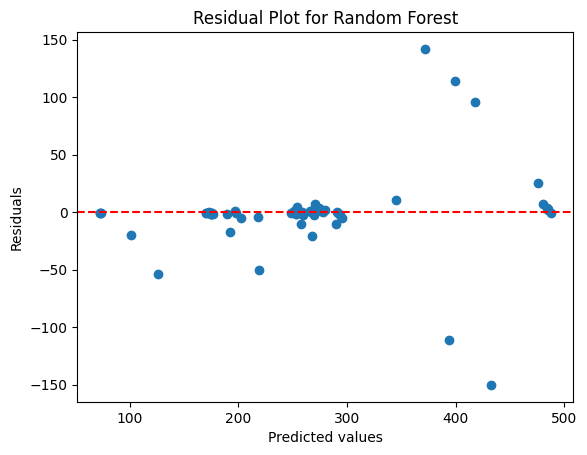

In [10]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

def augment_data(data, num_samples=10, perturbation_factor=0.05):
    augmented_data = [data.copy()]
    for _ in range(num_samples):
        new_data = data.copy()
        for i in range(len(data)):
            new_row = new_data.iloc[i].copy()
            new_row['Spindle speed (rpm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Spindle speed (rpm)']
            new_row['Feed Rate (mm/min)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Feed Rate (mm/min)']
            new_row['Depth of cut (mm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Depth of cut (mm)']
            augmented_data.append(pd.DataFrame([new_row]))
    return pd.concat(augmented_data, ignore_index=True)

data = pd.read_csv('/content/1.csv.csv', encoding='ISO-8859-1')

augmented_data = augment_data(data, num_samples=10)

X = augmented_data[['Spindle speed (rpm)', 'Feed Rate (mm/min)', 'Depth of cut (mm)']]
y = augmented_data['MRR(mm3/min)']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

poly_rf_pipeline = make_pipeline(PolynomialFeatures(), StandardScaler(), RandomForestRegressor(random_state=42))

param_grid_rf = {
    'randomforestregressor__n_estimators': [100, 200, 500],
    'randomforestregressor__max_depth': [10, 20, 30],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4],
    'polynomialfeatures__degree': [2, 3, 4]
}

grid_search_rf = GridSearchCV(poly_rf_pipeline, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_scaled, y)

best_poly_rf_model = grid_search_rf.best_estimator_
print(f"Best RF hyperparameters: {grid_search_rf.best_params_}")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

best_poly_rf_model.fit(X_train, y_train)

y_pred_rf_poly_mrr = best_poly_rf_model.predict(X_test)

mse_rf_poly = mean_squared_error(y_test, y_pred_rf_poly_mrr)
r2_rf_poly = r2_score(y_test, y_pred_rf_poly_mrr)
evs_rf_poly = explained_variance_score(y_test, y_pred_rf_poly_mrr)
mape_rf_poly = mean_absolute_percentage_error(y_test, y_pred_rf_poly_mrr)
print(f"Random Forest with Polynomial Features - MSE: {mse_rf_poly}, R²: {r2_rf_poly}, EVS: {evs_rf_poly}, MAPE: {mape_rf_poly}")

# Cross-validation
scores_rf = cross_val_score(best_poly_rf_model, X_scaled, y, cv=5, scoring='r2')
print(f"Cross-validated R-squared: {scores_rf.mean()}")

new_data = pd.DataFrame({
    'Spindle speed (rpm)': [175],
    'Feed Rate (mm/min)': [93],
    'Depth of cut (mm)': [0.1]
})

new_data_scaled = scaler.transform(new_data)

predicted_ra_rf = best_poly_rf_model.predict(new_data_scaled)
print(f"Predicted MRR(mm3/min) for input [400, 150, 0.5]: {predicted_ra_rf[0]}")

# Plot residuals
residuals_rf = y_test - y_pred_rf_poly_mrr
plt.scatter(y_pred_rf_poly_mrr, residuals_rf)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Random Forest')
plt.axhline(0, color='red', linestyle='--')
plt.show()

graph for 1% Zno (MRR)

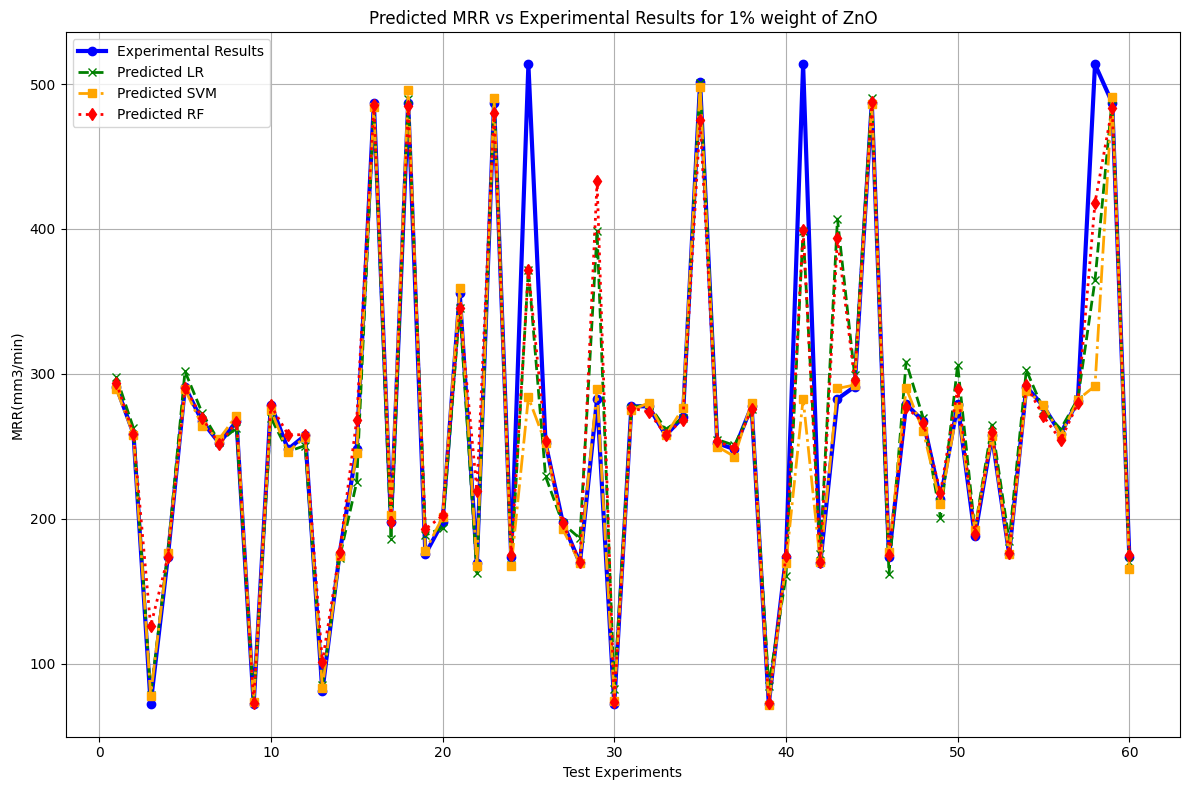

In [11]:
import matplotlib.pyplot as plt

# Assuming y_test contains the actual experimental results, and
# y_pred_1_sr, y_pred_1_svm_poly, y_pred_1_rf_poly contain the predictions from Linear Regression, SVM, and Random Forest respectively

# Define test experiments (This is optional if you don't have test_experiments as a separate array)
  # Assuming the test experiments are sequentially numbered

# Create a figure with a larger size to visualize all models clearly
plt.figure(figsize=(12, 8))

# Plot experimental results
plt.plot(test_experiments, y_test, label='Experimental Results', marker='o', linestyle='-', color='blue', linewidth=3)

# Plot Linear Regression predictions
plt.plot(test_experiments, y_pred_1_mrr, label='Predicted LR', marker='x', linestyle='--', color='green', markersize=6, linewidth=2)

# Plot SVM predictions
plt.plot(test_experiments, y_pred_1_svm_poly_mrr, label='Predicted SVM', marker='s', linestyle='-.', color='orange', markersize=6, linewidth=2)

# Plot Random Forest predictions
plt.plot(test_experiments, y_pred_rf_poly_mrr, label='Predicted RF', marker='d', linestyle=':', color='red', markersize=6, linewidth=2)

# Set labels and title
plt.xlabel('Test Experiments')
plt.ylabel('MRR(mm3/min)')
plt.title('Predicted MRR vs Experimental Results for 1% weight of ZnO')

# Add a grid for better visualization
plt.grid(True)

# Add a legend to differentiate between the models
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

7. Linear Regression Model using 1.5% to identify Sourface Roughness

Original Data:
  Experiment No.  Spindle speed (rpm)  Feed Rate (mm/min)  Depth of cut (mm)  \
0             1B                  175                  40                0.1   
1             2B                  175                  40                0.3   
2             3B                  175                  40                0.5   
3             4B                  175                  93                0.1   
4             5B                  175                  93                0.3   

   Surface Roughness (æm)  MRR(mm3/min)  
0                  0.5831      208.6062  
1                  3.0123      239.0742  
2                  4.9675      260.1981  
3                  4.1342      433.4958  
4                  4.3519      574.1748  

Augmented Data Head:
  Experiment No.  Spindle speed (rpm)  Feed Rate (mm/min)  Depth of cut (mm)  \
0             1B                175.0                40.0                0.1   
1             2B                175.0                40.0             

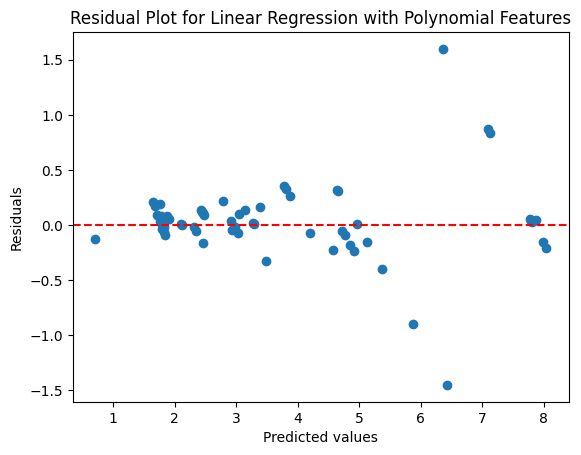

In [12]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline

def augment_data(data, num_samples=10, perturbation_factor=0.05):
    augmented_data = [data.copy()]
    for _ in range(num_samples):
        new_data = data.copy()
        for i in range(len(data)):
            new_row = new_data.iloc[i].copy()
            new_row['Spindle speed (rpm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Spindle speed (rpm)']
            new_row['Feed Rate (mm/min)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Feed Rate (mm/min)']
            new_row['Depth of cut (mm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Depth of cut (mm)']
            augmented_data.append(pd.DataFrame([new_row]))
    return pd.concat(augmented_data, ignore_index=True)

data = pd.read_csv('/content/1.5.csv.csv', encoding='ISO-8859-1')

print("Original Data:")
print(data.head())

augmented_data = augment_data(data, num_samples=10)

print("\nAugmented Data Head:")
print(augmented_data.head())

X = augmented_data[['Spindle speed (rpm)', 'Feed Rate (mm/min)', 'Depth of cut (mm)']]
y = augmented_data['Surface Roughness (æm)']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

poly = PolynomialFeatures(include_bias=False, interaction_only=False)

pipeline = make_pipeline(poly, LinearRegression())

param_grid = {
    'polynomialfeatures__degree': [2, 3, 4],
    'linearregression__fit_intercept': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_scaled, y)

best_model = grid_search.best_estimator_
print(f"Best hyperparameters found: {grid_search.best_params_}")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

best_model.fit(X_train, y_train)

y_pred_15_sr_lr = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_15_sr_lr)
r2 = r2_score(y_test, y_pred_15_sr_lr)
evs = explained_variance_score(y_test, y_pred_15_sr_lr)
mape = mean_absolute_percentage_error(y_test, y_pred_15_sr_lr)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Explained Variance Score: {evs}")
print(f"Mean Absolute Percentage Error: {mape}")


scores = cross_val_score(best_model, X_scaled, y, cv=5, scoring='r2')
print(f"Cross-validated R-squared: {scores.mean()}")


new_data = pd.DataFrame({
    'Spindle speed (rpm)': [320],
    'Feed Rate (mm/min)': [40],
    'Depth of cut (mm)': [0.1]
})


new_data_scaled = scaler.transform(new_data)

predicted_mrr = best_model.predict(new_data_scaled)
print(f"Predicted Surface Roughness (æm) for input [400, 150, 0.5]: {predicted_mrr[0]}")


residuals = y_test - y_pred_15_sr_lr
plt.scatter(y_pred_15_sr_lr, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Linear Regression with Polynomial Features')
plt.axhline(0, color='red', linestyle='--')
plt.show()

8. SVM using 1.5% to identify Surface Roughness

Best SVM hyperparameters: {'polynomialfeatures__degree': 2, 'svr__C': 10, 'svr__epsilon': 0.01, 'svr__gamma': 'scale', 'svr__kernel': 'poly'}
SVM with Polynomial Features - MSE: 0.29013450201878255, R²: 0.9308479712519284, EVS: 0.9328805582012549, MAPE: 0.043735705428191086
Cross-validated R-squared: 0.9201962878298963
Predicted Surface Roughness (æm) for input [400, 150, 0.5]: 2.6159257931608653


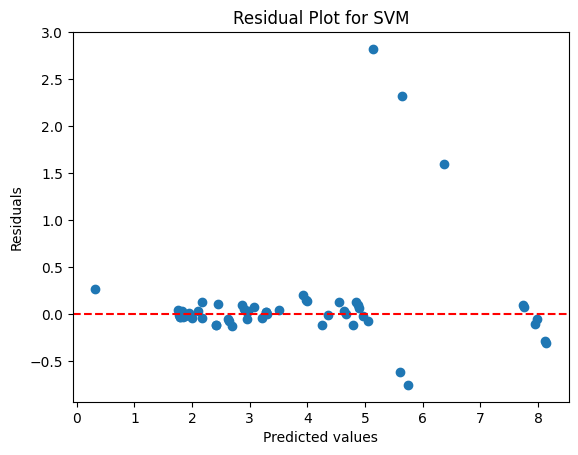

In [13]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

def augment_data(data, num_samples=10, perturbation_factor=0.05):
    augmented_data = [data.copy()]
    for _ in range(num_samples):
        new_data = data.copy()
        for i in range(len(data)):
            new_row = new_data.iloc[i].copy()
            new_row['Spindle speed (rpm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Spindle speed (rpm)']
            new_row['Feed Rate (mm/min)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Feed Rate (mm/min)']
            new_row['Depth of cut (mm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Depth of cut (mm)']
            augmented_data.append(pd.DataFrame([new_row]))
    return pd.concat(augmented_data, ignore_index=True)

data = pd.read_csv('/content/1.5.csv.csv', encoding='ISO-8859-1')

augmented_data = augment_data(data, num_samples=10)

X = augmented_data[['Spindle speed (rpm)', 'Feed Rate (mm/min)', 'Depth of cut (mm)']]
y = augmented_data['Surface Roughness (æm)']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
poly_svm_pipeline = make_pipeline(PolynomialFeatures(), StandardScaler(), SVR())

param_grid_svm = {
    'svr__kernel': ['rbf', 'poly'],
    'svr__C': [1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.5],
    'svr__gamma': ['scale', 'auto'],
    'polynomialfeatures__degree': [2, 3, 4]
}
grid_search_svm = GridSearchCV(poly_svm_pipeline, param_grid_svm, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svm.fit(X_scaled, y)

best_poly_svm_model = grid_search_svm.best_estimator_
print(f"Best SVM hyperparameters: {grid_search_svm.best_params_}")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

best_poly_svm_model.fit(X_train, y_train)

y_pred_15_svm_poly = best_poly_svm_model.predict(X_test)

mse_svm_poly = mean_squared_error(y_test, y_pred_15_svm_poly)
r2_svm_poly = r2_score(y_test, y_pred_15_svm_poly)
evs_svm_poly = explained_variance_score(y_test, y_pred_15_svm_poly)
mape_svm_poly = mean_absolute_percentage_error(y_test, y_pred_15_svm_poly)
print(f"SVM with Polynomial Features - MSE: {mse_svm_poly}, R²: {r2_svm_poly}, EVS: {evs_svm_poly}, MAPE: {mape_svm_poly}")

# Cross-validation
scores_svm = cross_val_score(best_poly_svm_model, X_scaled, y, cv=5, scoring='r2')
print(f"Cross-validated R-squared: {scores_svm.mean()}")

new_data = pd.DataFrame({
    'Spindle speed (rpm)': [320],
    'Feed Rate (mm/min)': [40],
    'Depth of cut (mm)': [0.1]
})

new_data_scaled = scaler.transform(new_data)

predicted_ra_svm = best_poly_svm_model.predict(new_data_scaled)
print(f"Predicted Surface Roughness (æm) for input [400, 150, 0.5]: {predicted_ra_svm[0]}")

# Plot residuals
residuals_svm = y_test - y_pred_15_svm_poly
plt.scatter(y_pred_15_svm_poly, residuals_svm)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for SVM')
plt.axhline(0, color='red', linestyle='--')
plt.show()

9. RF using 1.5% to identify Surface Roughness

Best RF hyperparameters: {'polynomialfeatures__degree': 3, 'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__n_estimators': 500}
Random Forest with Polynomial Features - MSE: 0.3555101721972452, R²: 0.9152660249747744, EVS: 0.9152744009982801, MAPE: 0.055192243423431445
Cross-validated R-squared: 0.9177813265937195
Predicted Surface Roughness (æm) for input [400, 150, 0.5]: 2.473114964116647


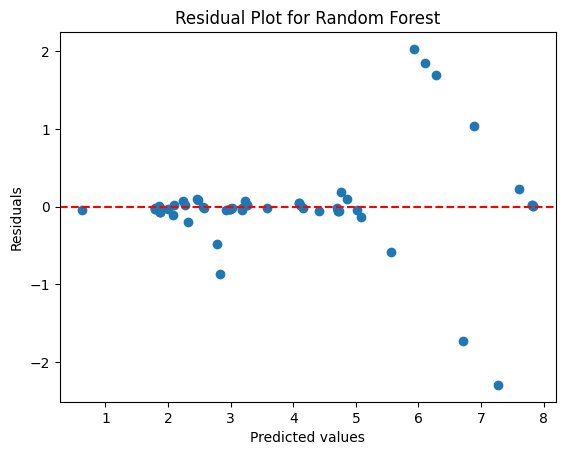

In [14]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

def augment_data(data, num_samples=10, perturbation_factor=0.05):
    augmented_data = [data.copy()]
    for _ in range(num_samples):
        new_data = data.copy()
        for i in range(len(data)):
            new_row = new_data.iloc[i].copy()
            new_row['Spindle speed (rpm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Spindle speed (rpm)']
            new_row['Feed Rate (mm/min)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Feed Rate (mm/min)']
            new_row['Depth of cut (mm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Depth of cut (mm)']
            augmented_data.append(pd.DataFrame([new_row]))
    return pd.concat(augmented_data, ignore_index=True)

data = pd.read_csv('/content/1.5.csv.csv', encoding='ISO-8859-1')

augmented_data = augment_data(data, num_samples=10)

X = augmented_data[['Spindle speed (rpm)', 'Feed Rate (mm/min)', 'Depth of cut (mm)']]
y = augmented_data['Surface Roughness (æm)']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

poly_rf_pipeline = make_pipeline(PolynomialFeatures(), StandardScaler(), RandomForestRegressor(random_state=42))

param_grid_rf = {
    'randomforestregressor__n_estimators': [100, 200, 500],
    'randomforestregressor__max_depth': [10, 20, 30],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4],
    'polynomialfeatures__degree': [2, 3, 4]
}

grid_search_rf = GridSearchCV(poly_rf_pipeline, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_scaled, y)

best_poly_rf_model = grid_search_rf.best_estimator_
print(f"Best RF hyperparameters: {grid_search_rf.best_params_}")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

best_poly_rf_model.fit(X_train, y_train)

y_pred_15_rf_poly_sr = best_poly_rf_model.predict(X_test)

mse_rf_poly = mean_squared_error(y_test, y_pred_15_rf_poly_sr)
r2_rf_poly = r2_score(y_test, y_pred_15_rf_poly_sr)
evs_rf_poly = explained_variance_score(y_test, y_pred_15_rf_poly_sr)
mape_rf_poly = mean_absolute_percentage_error(y_test, y_pred_15_rf_poly_sr)
print(f"Random Forest with Polynomial Features - MSE: {mse_rf_poly}, R²: {r2_rf_poly}, EVS: {evs_rf_poly}, MAPE: {mape_rf_poly}")

# Cross-validation
scores_rf = cross_val_score(best_poly_rf_model, X_scaled, y, cv=5, scoring='r2')
print(f"Cross-validated R-squared: {scores_rf.mean()}")

new_data = pd.DataFrame({
    'Spindle speed (rpm)': [320],
    'Feed Rate (mm/min)': [40],
    'Depth of cut (mm)': [0.1]
})

new_data_scaled = scaler.transform(new_data)

predicted_ra_rf = best_poly_rf_model.predict(new_data_scaled)
print(f"Predicted Surface Roughness (æm) for input [400, 150, 0.5]: {predicted_ra_rf[0]}")

# Plot residuals
residuals_rf = y_test - y_pred_15_rf_poly_sr
plt.scatter(y_pred_15_rf_poly_sr, residuals_rf)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Random Forest')
plt.axhline(0, color='red', linestyle='--')
plt.show()

graph for 1.5% Zno (SR)

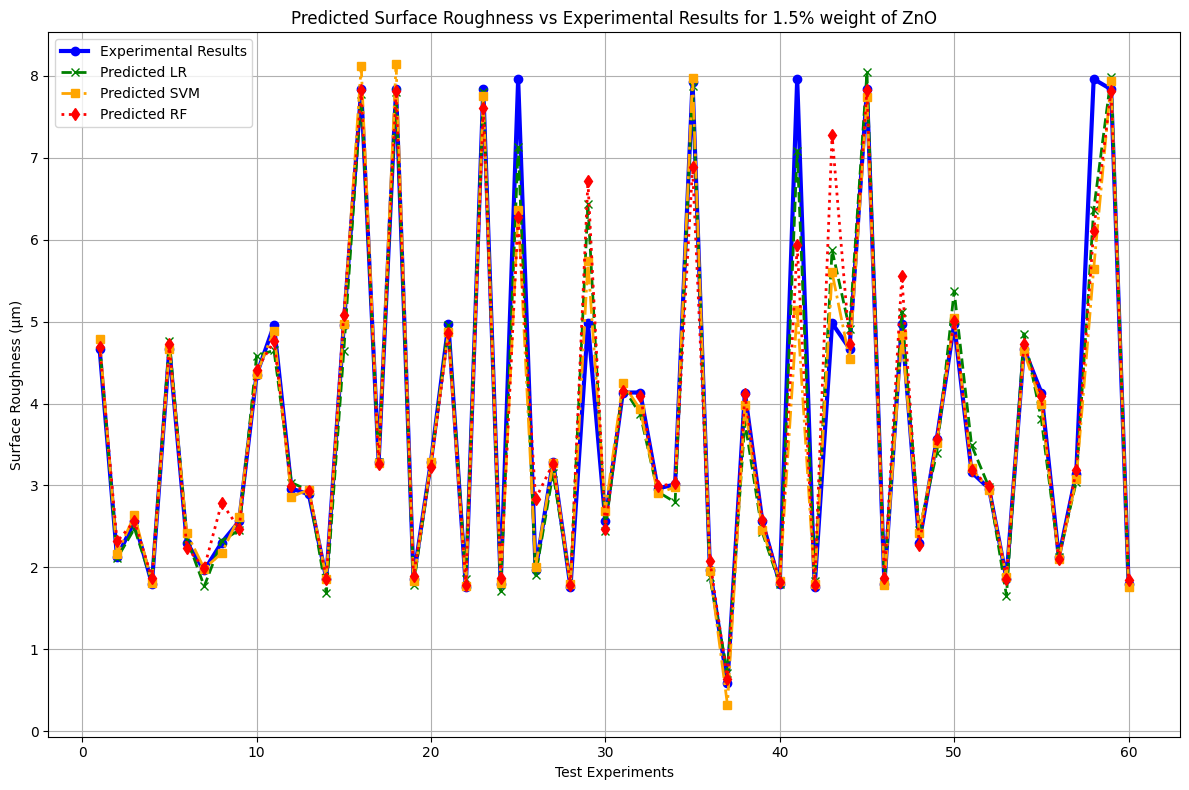

In [15]:
import matplotlib.pyplot as plt

# Assuming y_test contains the actual experimental results, and
# y_pred_1_sr, y_pred_1_svm_poly, y_pred_1_rf_poly contain the predictions from Linear Regression, SVM, and Random Forest respectively

# Define test experiments (This is optional if you don't have test_experiments as a separate array)
  # Assuming the test experiments are sequentially numbered

# Create a figure with a larger size to visualize all models clearly
plt.figure(figsize=(12, 8))

# Plot experimental results
plt.plot(test_experiments, y_test, label='Experimental Results', marker='o', linestyle='-', color='blue', linewidth=3)

# Plot Linear Regression predictions
plt.plot(test_experiments, y_pred_15_sr_lr, label='Predicted LR', marker='x', linestyle='--', color='green', markersize=6, linewidth=2)

# Plot SVM predictions
plt.plot(test_experiments, y_pred_15_svm_poly, label='Predicted SVM', marker='s', linestyle='-.', color='orange', markersize=6, linewidth=2)

# Plot Random Forest predictions
plt.plot(test_experiments, y_pred_15_rf_poly_sr, label='Predicted RF', marker='d', linestyle=':', color='red', markersize=6, linewidth=2)

# Set labels and title
plt.xlabel('Test Experiments')
plt.ylabel('Surface Roughness (µm)')
plt.title('Predicted Surface Roughness vs Experimental Results for 1.5% weight of ZnO')

# Add a grid for better visualization
plt.grid(True)

# Add a legend to differentiate between the models
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

10. Linear Regression Model using 1.5% to identify MRR

Original Data:
  Experiment No.  Spindle speed (rpm)  Feed Rate (mm/min)  Depth of cut (mm)  \
0             1B                  175                  40                0.1   
1             2B                  175                  40                0.3   
2             3B                  175                  40                0.5   
3             4B                  175                  93                0.1   
4             5B                  175                  93                0.3   

   Surface Roughness (æm)  MRR(mm3/min)  
0                  0.5831      208.6062  
1                  3.0123      239.0742  
2                  4.9675      260.1981  
3                  4.1342      433.4958  
4                  4.3519      574.1748  

Augmented Data Head:
  Experiment No.  Spindle speed (rpm)  Feed Rate (mm/min)  Depth of cut (mm)  \
0             1B                175.0                40.0                0.1   
1             2B                175.0                40.0             

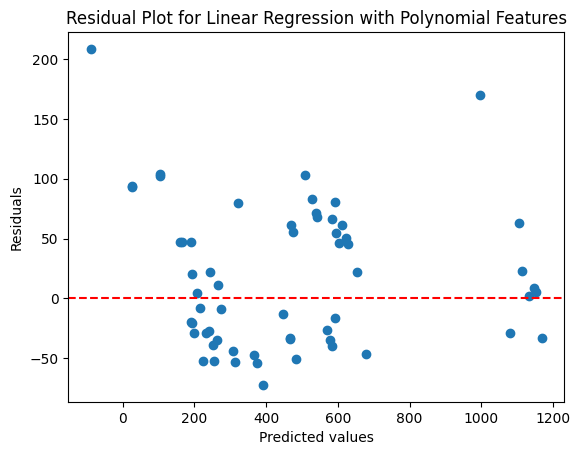

In [16]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline

def augment_data(data, num_samples=10, perturbation_factor=0.05):
    augmented_data = [data.copy()]
    for _ in range(num_samples):
        new_data = data.copy()
        for i in range(len(data)):
            new_row = new_data.iloc[i].copy()
            new_row['Spindle speed (rpm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Spindle speed (rpm)']
            new_row['Feed Rate (mm/min)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Feed Rate (mm/min)']
            new_row['Depth of cut (mm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Depth of cut (mm)']
            augmented_data.append(pd.DataFrame([new_row]))
    return pd.concat(augmented_data, ignore_index=True)

data = pd.read_csv('/content/1.5.csv.csv', encoding='ISO-8859-1')

print("Original Data:")
print(data.head())

augmented_data = augment_data(data, num_samples=10)

print("\nAugmented Data Head:")
print(augmented_data.head())

X = augmented_data[['Spindle speed (rpm)', 'Feed Rate (mm/min)', 'Depth of cut (mm)']]
y = augmented_data['MRR(mm3/min)']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

poly = PolynomialFeatures(include_bias=False, interaction_only=False)

pipeline = make_pipeline(poly, LinearRegression())

param_grid = {
    'polynomialfeatures__degree': [2, 3, 4],
    'linearregression__fit_intercept': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_scaled, y)

best_model = grid_search.best_estimator_
print(f"Best hyperparameters found: {grid_search.best_params_}")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

best_model.fit(X_train, y_train)

y_pred_15_lr_mrr = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_15_lr_mrr)
r2 = r2_score(y_test, y_pred_15_lr_mrr)
evs = explained_variance_score(y_test, y_pred_15_lr_mrr)
mape = mean_absolute_percentage_error(y_test, y_pred_15_lr_mrr)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Explained Variance Score: {evs}")
print(f"Mean Absolute Percentage Error: {mape}")

scores = cross_val_score(best_model, X_scaled, y, cv=5, scoring='r2')
print(f"Cross-validated R-squared: {scores.mean()}")

new_data = pd.DataFrame({
    'Spindle speed (rpm)': [530],  # example spindle speed
    'Feed Rate (mm/min)': [93],  # example feed rate
    'Depth of cut (mm)': [0.1]   # example depth of cut
})

new_data_scaled = scaler.transform(new_data)

predicted_mrr = best_model.predict(new_data_scaled)
print(f"Predicted MRR(mm3/min) for input [400, 150, 0.5]: {predicted_mrr[0]}")

# Plot residuals
residuals = y_test - y_pred_15_lr_mrr
plt.scatter(y_pred_15_lr_mrr, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Linear Regression with Polynomial Features')
plt.axhline(0, color='red', linestyle='--')
plt.show()

11. SVM using 1.5% to identify MRR

Best SVM hyperparameters: {'polynomialfeatures__degree': 2, 'svr__C': 100, 'svr__epsilon': 0.5, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
SVM with Polynomial Features - MSE: 1163.6305610876627, R²: 0.9881381572069544, EVS: 0.9887315869654622, MAPE: 0.03338028584349121
Cross-validated R-squared: 0.9865466499972916
Predicted MRR(mm3/min) for input [400, 150, 0.5]: 317.18390131464776


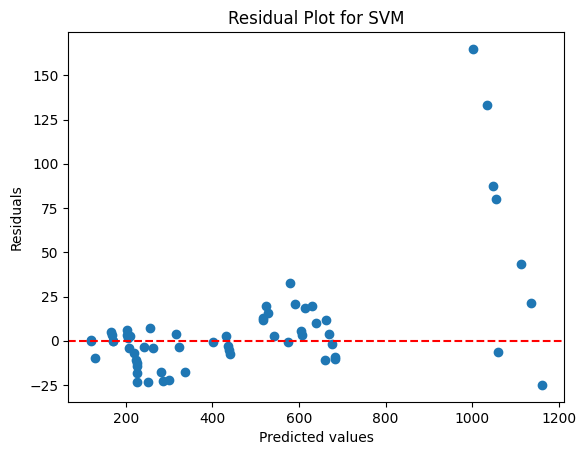

In [17]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

def augment_data(data, num_samples=10, perturbation_factor=0.05):
    augmented_data = [data.copy()]
    for _ in range(num_samples):
        new_data = data.copy()
        for i in range(len(data)):
            new_row = new_data.iloc[i].copy()
            new_row['Spindle speed (rpm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Spindle speed (rpm)']
            new_row['Feed Rate (mm/min)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Feed Rate (mm/min)']
            new_row['Depth of cut (mm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Depth of cut (mm)']
            augmented_data.append(pd.DataFrame([new_row]))
    return pd.concat(augmented_data, ignore_index=True)

data = pd.read_csv('/content/1.5.csv.csv', encoding='ISO-8859-1')

augmented_data = augment_data(data, num_samples=10)

X = augmented_data[['Spindle speed (rpm)', 'Feed Rate (mm/min)', 'Depth of cut (mm)']]
y = augmented_data['MRR(mm3/min)']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

poly_svm_pipeline = make_pipeline(PolynomialFeatures(), StandardScaler(), SVR())

param_grid_svm = {
    'svr__kernel': ['rbf', 'poly'],
    'svr__C': [1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.5],
    'svr__gamma': ['scale', 'auto'],
    'polynomialfeatures__degree': [2, 3, 4]
}

grid_search_svm = GridSearchCV(poly_svm_pipeline, param_grid_svm, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svm.fit(X_scaled, y)

best_poly_svm_model = grid_search_svm.best_estimator_
print(f"Best SVM hyperparameters: {grid_search_svm.best_params_}")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

best_poly_svm_model.fit(X_train, y_train)

y_pred_15_svm_poly_mrr = best_poly_svm_model.predict(X_test)

mse_svm_poly = mean_squared_error(y_test, y_pred_15_svm_poly_mrr)
r2_svm_poly = r2_score(y_test, y_pred_15_svm_poly_mrr)
evs_svm_poly = explained_variance_score(y_test, y_pred_15_svm_poly_mrr)
mape_svm_poly = mean_absolute_percentage_error(y_test, y_pred_15_svm_poly_mrr)
print(f"SVM with Polynomial Features - MSE: {mse_svm_poly}, R²: {r2_svm_poly}, EVS: {evs_svm_poly}, MAPE: {mape_svm_poly}")

# Cross-validation
scores_svm = cross_val_score(best_poly_svm_model, X_scaled, y, cv=5, scoring='r2')
print(f"Cross-validated R-squared: {scores_svm.mean()}")

new_data = pd.DataFrame({
    'Spindle speed (rpm)': [530],
    'Feed Rate (mm/min)': [93],
    'Depth of cut (mm)': [0.1]
})

new_data_scaled = scaler.transform(new_data)

predicted_ra_svm = best_poly_svm_model.predict(new_data_scaled)
print(f"Predicted MRR(mm3/min) for input [400, 150, 0.5]: {predicted_ra_svm[0]}")

# Plot residuals
residuals_svm = y_test - y_pred_15_svm_poly_mrr
plt.scatter(y_pred_15_svm_poly_mrr, residuals_svm)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for SVM')
plt.axhline(0, color='red', linestyle='--')
plt.show()

12. RF using 1.5% to identify MRR

Best RF hyperparameters: {'polynomialfeatures__degree': 2, 'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 500}
Random Forest with Polynomial Features - MSE: 416.0534277766018, R²: 0.9957588254220645, EVS: 0.9958563625225609, MAPE: 0.014813172554978531
Cross-validated R-squared: 0.9903012311693946
Predicted MRR(mm3/min) for input [400, 150, 0.5]: 171.8043508000012


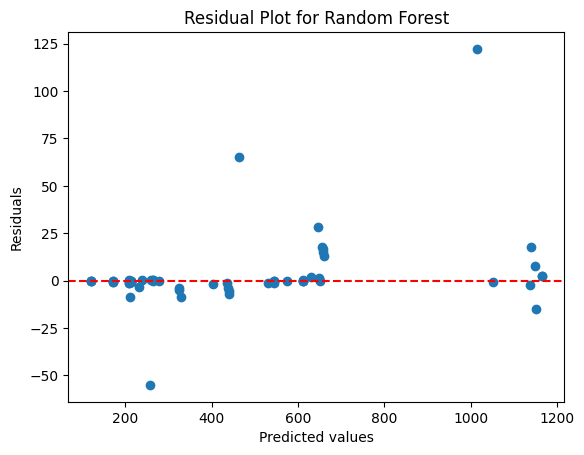

In [18]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

def augment_data(data, num_samples=10, perturbation_factor=0.05):
    augmented_data = [data.copy()]
    for _ in range(num_samples):
        new_data = data.copy()
        for i in range(len(data)):
            new_row = new_data.iloc[i].copy()
            new_row['Spindle speed (rpm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Spindle speed (rpm)']
            new_row['Feed Rate (mm/min)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Feed Rate (mm/min)']
            new_row['Depth of cut (mm)'] += random.uniform(-perturbation_factor, perturbation_factor) * new_row['Depth of cut (mm)']
            augmented_data.append(pd.DataFrame([new_row]))
    return pd.concat(augmented_data, ignore_index=True)

data = pd.read_csv('/content/1.5.csv.csv', encoding='ISO-8859-1')

augmented_data = augment_data(data, num_samples=10)

X = augmented_data[['Spindle speed (rpm)', 'Feed Rate (mm/min)', 'Depth of cut (mm)']]
y = augmented_data['MRR(mm3/min)']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

poly_rf_pipeline = make_pipeline(PolynomialFeatures(), StandardScaler(), RandomForestRegressor(random_state=42))

param_grid_rf = {
    'randomforestregressor__n_estimators': [100, 200, 500],
    'randomforestregressor__max_depth': [10, 20, 30],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4],
    'polynomialfeatures__degree': [2, 3, 4]
}

grid_search_rf = GridSearchCV(poly_rf_pipeline, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_scaled, y)

best_poly_rf_model = grid_search_rf.best_estimator_
print(f"Best RF hyperparameters: {grid_search_rf.best_params_}")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

best_poly_rf_model.fit(X_train, y_train)

y_pred_15_rf_poly_mrr = best_poly_rf_model.predict(X_test)

mse_rf_poly = mean_squared_error(y_test, y_pred_15_rf_poly_mrr)
r2_rf_poly = r2_score(y_test, y_pred_15_rf_poly_mrr)
evs_rf_poly = explained_variance_score(y_test, y_pred_15_rf_poly_mrr)
mape_rf_poly = mean_absolute_percentage_error(y_test, y_pred_15_rf_poly_mrr)
print(f"Random Forest with Polynomial Features - MSE: {mse_rf_poly}, R²: {r2_rf_poly}, EVS: {evs_rf_poly}, MAPE: {mape_rf_poly}")

# Cross-validation
scores_rf = cross_val_score(best_poly_rf_model, X_scaled, y, cv=5, scoring='r2')
print(f"Cross-validated R-squared: {scores_rf.mean()}")

new_data = pd.DataFrame({
    'Spindle speed (rpm)': [320],
    'Feed Rate (mm/min)': [40],
    'Depth of cut (mm)': [0.1]
})

new_data_scaled = scaler.transform(new_data)

predicted_ra_rf = best_poly_rf_model.predict(new_data_scaled)
print(f"Predicted MRR(mm3/min) for input [400, 150, 0.5]: {predicted_ra_rf[0]}")

# Plot residuals
residuals_rf = y_test - y_pred_15_rf_poly_mrr
plt.scatter(y_pred_15_rf_poly_mrr, residuals_rf)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Random Forest')
plt.axhline(0, color='red', linestyle='--')
plt.show()

graph for 1.5% Zno (MRR)

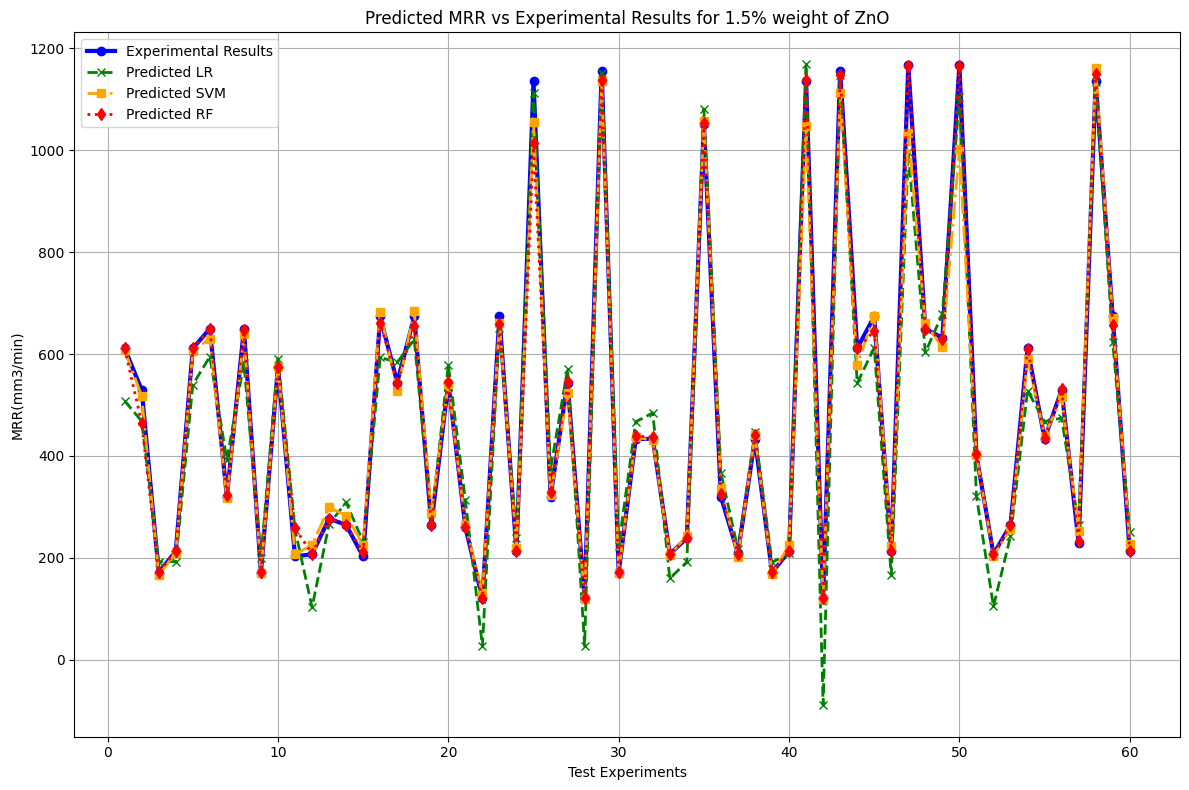

In [19]:
import matplotlib.pyplot as plt

# Assuming y_test contains the actual experimental results, and
# y_pred_1_sr, y_pred_1_svm_poly, y_pred_1_rf_poly contain the predictions from Linear Regression, SVM, and Random Forest respectively

# Define test experiments (This is optional if you don't have test_experiments as a separate array)
  # Assuming the test experiments are sequentially numbered

# Create a figure with a larger size to visualize all models clearly
plt.figure(figsize=(12, 8))

# Plot experimental results
plt.plot(test_experiments, y_test, label='Experimental Results', marker='o', linestyle='-', color='blue', linewidth=3)

# Plot Linear Regression predictions
plt.plot(test_experiments, y_pred_15_lr_mrr, label='Predicted LR', marker='x', linestyle='--', color='green', markersize=6, linewidth=2)

# Plot SVM predictions
plt.plot(test_experiments, y_pred_15_svm_poly_mrr, label='Predicted SVM', marker='s', linestyle='-.', color='orange', markersize=6, linewidth=2)

# Plot Random Forest predictions
plt.plot(test_experiments, y_pred_15_rf_poly_mrr, label='Predicted RF', marker='d', linestyle=':', color='red', markersize=6, linewidth=2)

# Set labels and title
plt.xlabel('Test Experiments')
plt.ylabel('MRR(mm3/min)')
plt.title('Predicted MRR vs Experimental Results for 1.5% weight of ZnO')

# Add a grid for better visualization
plt.grid(True)

# Add a legend to differentiate between the models
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()